In [1]:
#Define which area you'd like to be running the tool on
county = "SanBenitoCounty"
state = "California"

In [2]:
#Define the total radius you'd like to search for structures within. Eg. 4800m: Looking for structures within 4800m of a high fuel source.
structure_radius = 4800#meters
fuel_radius = 500#meters

In [3]:
import numpy as np
import json

In [4]:
# Helper function to determine what index a certain longlat is within the array
# Determines the xy coordinates given the reverse transformer and then determines given those, how many indices from the origin of the dataset it is

# lat_long: the given lat long that we are interested in finding the index for
# affine: the affine map for the tiff in question
# reverse_transformer: A transformer that can convert lat, long coordinates into x, y in EPSG:5070 (Continental US)
def find_index(lat_long: tuple, affine, reverse_transformer):
    xy = reverse_transformer.transform(lat_long[0], lat_long[1])
    return ((affine[5] - xy[1]) / affine[0]  , (xy[0] - affine[2]) / affine[0])

# <span style='background :yellow' > IF YOU'VE RAN THIS PART ALREADY FOR THE COUNTY, SKIP DOWN TO THE NEXT TEXT CELL </span>

***
***
***

In [ ]:
# https://landfire.gov/fbfm40.php

In [5]:
#Load in the landfire fuel dataset. This might take a few minutes
import rasterio
from rasterio.plot import show
fp = 'Fuel_Vegetation_Cover_CONUS.tif'
img = rasterio.open(fp)
affine = img.transform
imarray = img.read(1)

In [ ]:
# https://public.opendatasoft.com/explore/dataset/us-county-boundaries/table/?disjunctive.statefp&disjunctive.countyfp&disjunctive.name&disjunctive.namelsad&disjunctive.stusab&disjunctive.state_name&refine.name=Boulder

In [7]:
#After you've downloaded the polygon representing the county boundaries from above, load it in. Sometimes this will return an error (see comment on line 4)
with open(f"{county}-polygon.json") as f:
  data = json.load(f)
coords = data[0]['fields']['geo_shape']["coordinates"][0] #sometimes this needs an extra [0] at the end
arr = np.array(coords)
arr.shape

(6517, 2)

In [8]:
# Create a polygon object that can check if a point is inside it
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
poly = list(arr)
polygon = Polygon(poly)

In [9]:
# Set up the transformers which can change the coordinate reference system from longlat to Continental USA xy
from pyproj import Transformer
from rasterio import Affine

landfire_affine = Affine(30.0, 0.0, -2362395.000000001, 0.0, -30.0, 3267405.0000000037)
transformer = Transformer.from_crs("epsg:5070", "epsg:4326")#Change to 32610 which is the salo epsg
reverse_transformer = Transformer.from_crs("epsg:4326", "epsg:5070")#Change to 32610 which is the salo epsg

In [10]:
# Determine what the origin and end indices are of the county we are looking at. This helps to isolate a subsection of the continental USA to improve efficiency.
iorig, jorig = find_index((polygon.bounds[3], polygon.bounds[0]), landfire_affine, reverse_transformer)
iend, jend = find_index((polygon.bounds[1], polygon.bounds[2]), landfire_affine, reverse_transformer)

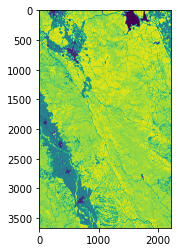

<AxesSubplot:>

In [11]:
# Creates the slice of the continental US. At the end, it shows a matrix version of the county. It is bounded by the extremes of the county polygon.
portion = imarray[int(iorig):int(iend) + 1]
new_arr = []
for i in range(len(portion)):
    new_arr.append(portion[i][int(jorig):int(jend) + 1])
show(new_arr)

In [12]:
new_arr = np.array(new_arr)

0%
0.051217079162597656
1%
3.03969407081604
1%
8.321145057678223
2%
16.200862169265747
3%
25.851675033569336
4%
40.82938003540039
5%
54.75323009490967
6%
71.08654189109802
7%
89.47714400291443
8%
110.09990811347961
9%
133.14888215065002
10%
158.26288294792175
11%
185.97182393074036
12%
215.40491890907288
13%
247.16218400001526
14%
281.1419401168823
15%
317.4556450843811
16%
357.41055703163147
17%
396.87709307670593
18%
436.1361970901489
19%
475.17132210731506
20%
514.4671940803528
21%
553.5672109127045
22%
592.7115519046783
23%
631.7998161315918
24%
670.8705880641937
25%
710.4182498455048
26%
749.7426500320435
27%
789.0928540229797
28%
828.4417278766632
29%
867.6831200122833
30%
906.7768139839172
31%
945.7347271442413
32%
984.7518210411072
33%
1023.8521020412445
34%
1062.9295899868011
35%
1101.9752638339996
36%
1141.07372713089
37%
1180.0651829242706
38%
1219.0667538642883
39%
1258.4172132015228
40%
1297.6092159748077
41%
1337.038388967514
42%
1376.053682088852
43%
1415.027986049652
44

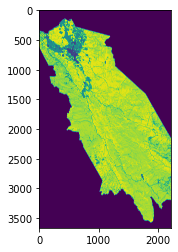

<AxesSubplot:>

In [14]:
# Since the matrix above includes more than just the county we are looking for, this checks every single point to see if it is contained within the polygon and if it isn't change it to 0
# so that further analysis does not find high fuel points outside of the county
import time
start_time = time.time()
arr_len = len(new_arr)
for i in range(len(new_arr)):
    for j in range(len(new_arr[0])):
        longlat = affine * (int(jorig) + j, int(iorig) + i)
        longlat = transformer.transform(longlat[0], longlat[1])
        point = Point(longlat[1], longlat[0])
        if not polygon.contains(point):
            new_arr[i][j] = 0
    if i % (arr_len // 100) == 0:
        print(str(int((i + 1) / (arr_len) * 100)) + "%")
        print(time.time() - start_time)
show(new_arr)

In [15]:
# Save the cropped matrix so that in the future, this step may be skipped.
import pickle
pickle_out = open(f"{county}LandFireCategorizationArray.pickle", "wb")
pickle.dump(new_arr, pickle_out)
pickle_out.close()

In [16]:
# Creates a dictionary to store the x,y and fuel categorizations for easy access
fuel_dict = {}
i = int(iorig)
while i < len(new_arr) + int(iorig):
    j = int(jorig)
    while j < len(new_arr[0]) + int(jorig):
        epsg_coords = affine * (j, i)
        x = epsg_coords[0]
        y = epsg_coords[1]
        fuel_dict[(x, y)] = imarray[i][j]
        j += 1
    i += 1
    if (i - int(iorig)) % (len(new_arr) // 100) == 0:
        print(str(int((i - int(iorig) + 1) / len(new_arr) * 100)) + "%")

1%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%


In [17]:
# Saves the dictionary so that in the future, this step may be skipped.
import pickle
pickle_out = open(f"{county}LandFireFuelXY.pickle", "wb")
pickle.dump(fuel_dict, pickle_out)
pickle_out.close()

In [18]:
# https://github.com/microsoft/USBuildingFootprints

In [19]:
# Once having downloaded the proper state geojson from the link above, this works to create a kdtree that can referenced to efficiently see how many buildings are within a certain radius.

import geopandas as gpd
from scipy import spatial
import pickle
import time

df = gpd.read_file(f'{state}.geojson')
xys = []
df_len = len(df)
start_time = time.time()

for i in range(df_len):
    row = df.iloc[i]
    try:
        xy = reverse_transformer.transform(df.iloc[i]['geometry'].centroid.xy[1][0], df.iloc[i]['geometry'].centroid.xy[0][0])
        xys.append(xy)
    except:
        print(row)
    if i % (df_len // 100) == 0:
        print(str(int((i + 1) / (df_len) * 100)) + "%")
        print(time.time() - start_time)
        
address_tree = spatial.KDTree(xys)
pickle_out = open(f"{state}BuildingTree.pickle", "wb")
pickle.dump(tree, pickle_out)
pickle_out.close()

0%
0.03585100173950195
1%
45.123045206069946
2%
89.30897402763367
3%
133.8147211074829
4%
178.14571809768677
5%
222.75446128845215
6%
266.8630950450897
7%
311.16281819343567
8%
355.3317060470581
8%
399.36161828041077
9%
443.3046143054962
10%
487.3962631225586
11%
531.4652092456818
12%
575.490602016449
13%
619.4845321178436
14%
663.712639093399
15%
708.0053632259369
16%
752.098108291626
17%
796.0765511989594
18%
840.1488320827484
19%
884.792622089386
20%
929.2159221172333
21%
973.308776140213
22%
1017.2828171253204
23%
1061.2104392051697
24%
1105.2329893112183
25%
1149.2777609825134
26%
1193.605874300003
27%
1237.6000740528107
28%
1281.9834251403809
29%
1325.9463863372803
30%
1369.966052055359
31%
1414.026447057724
32%
1458.1012291908264
33%
1501.943956375122
34%
1545.9573743343353
35%
1590.0077381134033
36%
1633.9911160469055
37%
1678.035355091095
38%
1722.4162030220032
39%
1766.5455121994019
40%
1810.9214761257172
41%
1855.2650921344757
42%
1899.6556820869446
43%
1944.02365732193
44%


NameError: name 'tree' is not defined

***
***
***

# <span style='background :yellow' > ONCE YOU'VE RUN ALL THE ABOVE ONCE, ON SUBSEQUENT TRIALS, YOU CAN START FROM HERE </span>

In [20]:
#Load in the polygon already downloaded for the county

with open(f"{county}-polygon.json") as f:
  data = json.load(f)
coords = data[0]['fields']['geo_shape']["coordinates"][0] # Sometimes this needs an extra [0] at the end
arr = np.array(coords)
arr.shape

(6517, 2)

In [21]:
# Create polygon to check if longlat points are contained within it

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from rasterio import Affine
poly = list(arr)
polygon = Polygon(poly)

In [22]:
# Set up the transformers which can change the coordinate reference system from longlat to Continental USA xy

from pyproj import Transformer
transformer = Transformer.from_crs("epsg:5070", "epsg:4326")#Change to 32610 which is the salo epsg
reverse_transformer = Transformer.from_crs("epsg:4326", "epsg:5070")#Change to 32610 which is the salo epsg
landfire_affine = Affine(30.0, 0.0, -2362395.000000001, 0.0, -30.0, 3267405.0000000037)

In [23]:
# Determine what the origin and end indices are of the county we are looking at. This helps to isolate a subsection of the continental USA to improve efficiency.

iorig, jorig = find_index((polygon.bounds[3], polygon.bounds[0]), landfire_affine, reverse_transformer)
iend, jend = find_index((polygon.bounds[1], polygon.bounds[2]), landfire_affine, reverse_transformer)

In [24]:
# Load in the fuel dictionary to easily determine how much fuel is at each x,y point

import pickle
pickle_in = open(f"{county}LandFireFuelXY.pickle","rb")
fuel_dict = pickle.load(pickle_in)
fuel_dict_keys = list(fuel_dict.keys())
fuel_dict_keys.sort()

In [25]:
#Determine what the extremes of the fuel keys are to set up further analysis

xmin = float("inf")
xmax = 0
ymax = 0
ymin = float("inf")
for x, y in fuel_dict_keys:
    if x < xmin:
        xmin = x
    if x > xmax:
        xmax = x
    if y < ymin:
        ymin = y
    if y > ymax:
        ymax = y

In [26]:
# Create a fuel tree to be used in checking if there are large areas with fuel of the same type.
# Helps determine what other fuel points are around one to then, perform analysis on.

from scipy import spatial
fuel_tree_vals = []
fuel_dict_keys_len = len(fuel_dict_keys)
for i, key in enumerate(fuel_dict_keys):
    x = key[0]
    y = key[1]
    fuel_tree_vals.append((x, y))
    if i % (fuel_dict_keys_len // 100) == 0:
        print(str(int((i + 1) / (fuel_dict_keys_len) * 100)) + "%")
fuel_tree = spatial.KDTree(fuel_tree_vals)

0%
1%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%


In [27]:
import geopandas as gpd
from pyproj import Transformer
from scipy import spatial
import numpy as np
import json
from shapely.geometry import Point
import time
from shapely.geometry.polygon import Polygon
import pickle

df = gpd.read_file(f'{state}.geojson')

reverse_transformer = Transformer.from_crs("epsg:4326", "epsg:5070")#Change to 32610 which is the salo epsg
transformer = Transformer.from_crs("epsg:5070", "epsg:4326")

with open(f"{county}-polygon.json") as f:
  data = json.load(f)
coords = data[0]['fields']['geo_shape']["coordinates"][0] # This will sometimes need an extra [0] at the end
arr = np.array(coords)
poly = list(arr)
polygon = Polygon(poly)

xys = []
df_len = len(df)

start_time = time.time()
for i in range(df_len):
    row = df.iloc[i]
    try:
        xy = reverse_transformer.transform(df.iloc[i]['geometry'].centroid.xy[1][0], df.iloc[i]['geometry'].centroid.xy[0][0])
        xys.append(xy)
    except:
        print(row)
    if i % (df_len // 100) == 0:
        print(str(int((i + 1) / (df_len) * 100)) + "%")
        print(time.time() - start_time)
address_tree = spatial.KDTree(xys)

# Saves the dictionary so that in the future, this step may be skipped.

pickle_out = open(f"{state}BuildingTree.pickle", "wb")
pickle.dump(address_tree, pickle_out)
pickle_out.close()

0%
0.049514055252075195
1%
55.76401686668396
2%
109.78817796707153
3%
165.93118000030518
4%
224.6608531475067
5%
279.3701078891754
6%
334.253968000412
7%
390.28195786476135
8%
445.6097500324249
8%
500.9589970111847
9%
551.8934631347656
10%
606.7576961517334
11%
661.9244711399078
12%
708.0573089122772
13%
753.3933250904083
14%
798.6567180156708
15%
843.6251690387726
16%
888.8054730892181
17%
933.9981510639191
18%
979.5132448673248
19%
1024.9732220172882
20%
1070.6498460769653
21%
1116.22008395195
22%
1161.4592609405518
23%
1207.2230129241943
24%
1252.9999740123749
25%
1298.5037031173706
26%
1344.42622590065
27%
1390.712786912918
28%
1436.876893043518
29%
1482.5577580928802
30%
1529.4542100429535
31%
1575.6446180343628
32%
1621.969612121582
33%
1668.0106871128082
34%
1714.0625169277191
35%
1760.795569896698
36%
1807.5186021327972
37%
1854.4185869693756
38%
1900.928966999054
39%
1947.4028849601746
40%
1993.7885591983795
41%
2040.339241027832
42%
2088.189227104187
43%
2135.3826830387115
44

In [28]:
# Load in the structure tree to determine how many buildings are around a certain xy point

import pickle
pickle_in = open(f"{state}BuildingTree.pickle","rb")
address_tree = pickle.load(pickle_in)

In [29]:
# Helper function that finds the closest key to a given one so that they can query the dictionary to find out what kind of fuel is at that point
# Utilizes the kdtree to find out which is closest

# tree: the corresponding tree to be used. If we are looking for a fuel value, we need to get the fuel key using this function, so the fuel tree will be used
# tree_vals: the corresponding tree values for the tree (This is a list of all values contained inside the tree)
# key: the key of interest that we want to search around
# distance: Maximum distance to search. If distance is 500, then it will search 500m within the key and return the closest one. If none are found within that range, it returns the first
# tree value as it corresponds to 0 and does not interfere with the program
def find_closest_key(tree, tree_vals, key, distance):
    res = tree.query([(key[0], key[1])], distance_upper_bound = distance)
    if res[0][0] == float("inf"):
        return tree_vals[0]
    closest_key_index = res[1][0]
    closest_key_set = tree_vals[closest_key_index]
    return closest_key_set

In [30]:
#Helper function that enables a list of tuples to be sorted by any element

# sub_li: the sub list to be sorted
# index: the index to sort on
def Sort(sub_li, index):
    return(sorted(sub_li, key = lambda x: x[index]))    

In [31]:
# Define helper functions

import shapely
from shapely.geometry import Point
acceptable_fuel_codes = [101, 102, 103, 104, 105, 106, 107, 108, 109, 121, 122, 123, 124, 141, 142, 143, 144, 145, 146 , 147, 148, 149, 189]

# Given an x, y point it determines that total number of structures within a given radius
# tree: the corresponding tree. In this case, it is the address_tree
# x, y: the x, y point in EPSG:5070
# radius: the radius to search from the x, y point for houses
def sum_radius_addresses(address_tree, x, y, radius):
    total_value = 0
    distances, indices = address_tree.query([(x, y)], distance_upper_bound=radius, k=400000)
    distances = list(distances[0])
    indices = list(indices[0])
    total = 400000 - distances.count(float("inf"))
    return total

# Given an x, y point it determines the proportion of fuel cells that are within a certain radius that have a fuel category that BurnBot is interested in
# (If no other nearby cells are in the interested category, it will return a number close to 0)
# d: the fuel dictionary to determine if the (x, y)s observed are in the interested category
# tree: the correspondig tree. In this case, it is the fuel_tree
# tree_vals: the corresponding tree values to the tree
# x, y: the x, y point in EPSG:5070
# radius: the radius to search from the x, y point for fuel
def sum_radius_fuel(d, tree, tree_vals, x, y, radius):
#     et = int(((radius / 30) ** 2) * np.pi)
    distances, indices = tree.query([(x, y)], distance_upper_bound=radius, k=900)
    distances = list(distances[0])
    indices = list(indices[0])
    total = 900 - distances.count(float("inf"))
    total_valid = 0
    for i in range(total):
        if d[tree_vals[indices[i]]] in acceptable_fuel_codes:
            total_valid += 1
    if total == 0:
        return 0
    return total_valid / total

In [32]:
# Load in the categorization array to find clusters of fuel that BurnBot is interested in
import numpy as np
import pickle

pickle_in = open(f"{county}LandFireCategorizationArray.pickle","rb")
fuel_cat_array = pickle.load(pickle_in)
fuel_cat_array = np.array(fuel_cat_array)
#duration of firebrand 2-3 minutes according to https://www.fs.fed.us/psw/publications/weise/psw_2010_weise(koo)001.pdf

In [34]:
# Goes through the categorization array for the county and if a spot is of interest it converts it to a 1. If it is not, it converts it to 0

import time
start_time = time.time()
binary_fuel_arr = fuel_cat_array
for row in range(len(fuel_cat_array)):
    for col in range(len(fuel_cat_array[0])):
        binary_fuel_arr[row][col] = fuel_cat_array[row][col] in acceptable_fuel_codes
    if row % (len(fuel_cat_array) // 100) == 0:
        print(str(int((row + 1) / (len(fuel_cat_array)) * 100)) + "%")
        print(time.time() - start_time)

0%
0.06862592697143555
1%
2.551462173461914
1%
4.932742118835449
2%
7.302622079849243
3%
9.713692903518677
4%
11.982923030853271
5%
14.212532043457031
6%
16.476979970932007
7%
18.654109954833984
8%
20.813706159591675
9%
22.912851095199585
10%
24.938573122024536
11%
26.855123043060303
12%
28.79947304725647
13%
30.735096216201782
14%
32.879632234573364
15%
34.9126341342926
16%
36.891255140304565
17%
38.83869123458862
18%
40.80669808387756
19%
42.69495105743408
20%
44.56297707557678
21%
46.425241231918335
22%
48.21260213851929
23%
50.03476619720459
24%
51.878255128860474
25%
53.66526699066162
26%
55.52187514305115
27%
57.29224133491516
28%
59.03806495666504
29%
60.83991193771362
30%
62.60404109954834
31%
64.33223605155945
32%
66.03736019134521
33%
67.67783212661743
34%
69.37115406990051
35%
71.11430621147156
36%
72.84123229980469
37%
74.57140827178955
38%
76.34755992889404
39%
78.12249112129211
40%
79.96957421302795
41%
81.76318693161011
42%
83.54358196258545
43%
85.30160999298096
44%
87.

In [35]:
# Use scipy's find objects function to create clusters of fuel

from scipy.ndimage.measurements import label
from scipy.ndimage import generate_binary_structure, find_objects
s = generate_binary_structure(2, 2)
labeled_fuel_array, num_features = label(binary_fuel_arr, structure=s)
objects = find_objects(labeled_fuel_array)

In [36]:
# Sets up helpers

import rasterio
from rasterio import Affine
from rasterio.plot import show
burnable_spot_centers = []

# Given indices and an offset for the landfire image, determines the x, y coordinate of it
def get_xy(affine, i, j, ioffset, joffset):
    return affine * (j + joffset, i + ioffset)

landfire_affine = Affine(30.0, 0.0, -2362395.000000001, 0.0, -30.0, 3267405.0000000037)

In [37]:
# Goes through each of the clusters of fuel found previously and notes their centers. This is an imperfect approach that can certainly be refined.

for slices in objects:
    irange, jrange = slices[0].indices(len(fuel_cat_array)), slices[1].indices(len(fuel_cat_array[0]))
    mini, minj, maxi, maxj = irange[0], jrange[0], irange[1], jrange[1]
    xy = get_xy(landfire_affine, (mini + maxi) / 2, (minj + maxj) / 2, int(iorig), int(jorig))
    burnable_spot_centers.append(xy)

In [38]:
# Goes through the centers of areas of high fuel and collects data for what proportion of fuel within a 500m radius there is for each fuel key

start_time = time.time()
fuel_prop_dict = {}

for i, key in enumerate(burnable_spot_centers):
    fuel_prop_dict[key] = sum_radius_fuel(fuel_dict, fuel_tree, fuel_tree_vals, key[0], key[1], fuel_radius)
    if i % (len(burnable_spot_centers) // 100) == 0:
        print(str(int((i + 1) / (len(burnable_spot_centers)) * 100)) + "%")
        print(time.time() - start_time)

0%
0.22142910957336426
1%
4.598368167877197
2%
8.516218900680542
3%
12.020877838134766
4%
15.551998138427734
4%
19.074893951416016
5%
22.616289138793945
6%
26.413444995880127
7%
30.088629007339478
8%
33.813079833984375
9%
37.39656209945679
10%
40.83265280723572
11%
44.1637909412384
12%
47.41275906562805
13%
50.527815103530884
14%
53.72429084777832
15%
57.05179810523987
16%
60.448731899261475
17%
63.97404718399048
18%
67.65743112564087
19%
71.21500611305237
20%
74.66529893875122
21%
78.07929301261902
22%
81.53340816497803
23%
85.0039529800415
24%
88.41503596305847
25%
91.6344940662384
26%
94.68015503883362
27%
98.08893704414368
28%
101.39661502838135
29%
104.74966192245483
30%
108.2440459728241
31%
111.75074791908264
32%
115.27562093734741
33%
118.91386413574219
34%
122.45354294776917
35%
126.12091398239136
36%
129.64364409446716
37%
133.2826850414276
38%
137.02594304084778
39%
140.79276299476624
40%
144.49820494651794
41%
148.16203093528748
42%
151.62394881248474
43%
155.22243309020996

In [39]:
pickle_out = open(f"{county}FuelPropDict.pickle", "wb")
pickle.dump(fuel_prop_dict, pickle_out)
pickle_out.close()

In [40]:
pickle_in = open(f"{county}FuelPropDict.pickle","rb")
fuel_prop_dict = pickle.load(pickle_in)

In [41]:
# Goes through each proportion of fuel at each key and if most of the area is relevant to BurnBot, it adds it to an important key list

high_fuel_keys = []
for key, val in fuel_prop_dict.items():
    if val >= 0.7:
        high_fuel_keys.append(key)

In [42]:
# For each important key, the total number of structures within the earlier specified radius is counted

import time
start_time = time.time()
risk_dict = {}
hfk_len = len(high_fuel_keys)
for i, (x,y) in enumerate(high_fuel_keys):
    risk_dict[(x, y)] = sum_radius_addresses(address_tree, x, y, structure_radius)
    if i % (hfk_len // 10) == 0:
        print(str(int((i + 1) / (hfk_len) * 100)) + "%")
        print(time.time() - start_time)

0%
0.07346773147583008
10%
1.8313877582550049
20%
3.606543779373169
30%
5.391035795211792
40%
7.1695897579193115
50%
8.955476999282837
60%
10.70117974281311
70%
12.497710704803467
80%
14.282510757446289
90%
16.05952477455139
100%
17.844244956970215


In [43]:
# turning the dictionary into an array

risk_arr = []
for key, val in risk_dict.items():
    risk_arr.append([key, val])

In [44]:
# sorting the array according to values ascending

risk_arr = Sort(risk_arr, 1)

In [45]:
# changes the array so it is sorted according to values descending

risk_arr.reverse()

In [46]:
# collects all risk_arr_keys

risk_arr_keys = [row[0] for row in risk_arr]

In [47]:
# constructs a tree out of the risk keys so that it can perform a suppression algorithm to make sure that two points close together do not both register

from scipy import spatial
risk_tree_vals = []
risk_arr_keys_len = len(risk_arr_keys)
for i, key in enumerate(risk_arr_keys):
    x = key[0]
    y = key[1]
    risk_tree_vals.append((x, y))
risk_tree = spatial.KDTree(risk_tree_vals)

In [48]:
# Alarm suppression algorithm that disables points that are too close to eachother to register

new_risk_dict = {}
blacklisted_keys = []
for x, y in risk_arr_keys:
    if (x, y) not in blacklisted_keys:
        distances, indices = risk_tree.query([(x, y)], distance_upper_bound=3000, k=500)
        distances = list(distances[0])
        indices = list(indices[0])
        total = 500 - distances.count(float("inf"))
        xtotal = x
        ytotal = y
        xcount = 1
        ycount = 1
        max_structures = risk_dict[(x, y)]
        for i in range(total):
            key = risk_tree_vals[indices[i]]
            if key not in blacklisted_keys:
                xtotal += key[0]
                ytotal += key[1]
                xcount += 1
                ycount += 1
                max_structures = max(risk_dict[key], max_structures)
                blacklisted_keys.append(key)

        xavg = xtotal / xcount
        yavg = ytotal / ycount

        new_risk_dict[(xavg, yavg)] = max_structures

In [49]:
# creates a new risk list out of the remaining dictionary

new_risk_arr = []
for key, val in new_risk_dict.items():
    new_risk_arr.append([key, val])

In [50]:
# sorts the new risk list ascending by value

new_risk_arr = Sort(new_risk_arr, 1)

In [51]:
# reverses the new risk list so it is descending by value

new_risk_arr.reverse()

In [52]:
# converts the new risk list to be in lat, long form so it is easier to read

longlat_risk_arr = []
for xy, val in new_risk_arr:
    longlat = transformer.transform(xy[0], xy[1])
    longlat_risk_arr.append((longlat, val))

In [53]:
longlat_risk_arr

[((36.820431935847, -121.34512848757345), 9748),
 ((36.85648043682578, -121.34052724123563), 8052),
 ((36.79264249805268, -121.3894027024512), 7323),
 ((36.83325943722267, -121.30230482059486), 2012),
 ((36.869661894564516, -121.56922028117563), 1878),
 ((36.771396421097926, -121.36790796486419), 1784),
 ((36.949882204222234, -121.3634130484399), 1646),
 ((36.81887636223949, -121.53086862296735), 1637),
 ((36.91075899642012, -121.32571258202341), 1633),
 ((36.83203167801744, -121.56962251584503), 1527),
 ((36.80891988030331, -121.48420071371405), 919),
 ((36.92499947533396, -121.43857232254499), 874),
 ((36.79795873606645, -121.45394151761371), 861),
 ((36.75568616393541, -121.34551511077285), 830),
 ((36.79072420331777, -121.29560567670406), 777),
 ((36.732520124923205, -121.31402456237555), 331),
 ((36.9392458574836, -121.29777581986505), 305),
 ((36.68969350960492, -121.25662018512142), 261),
 ((36.78659122621936, -121.51544072751645), 259),
 ((36.68688390422094, -121.30881906839315

In [54]:
# Saves the results so they can be opened later

pickle_out = open(f"{county}RiskDict.pickle", "wb")
pickle.dump(risk_dict, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open(f"{county}RiskDict.pickle","rb")
risk_dict = pickle.load(pickle_in)